In [3]:
import copy
import time

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

## Load Librispeech Dataset

In [15]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("librispeech-mixed") 
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s"


 Loaded voxceleb1identification-4s


Count number of unique speakers

In [8]:
len(np.unique(speaker_mfcc_db["speaker_id"]))

1251

Count the number of samples for each speaker_id

In [9]:
speaker_mfcc_db.groupby('speaker_id').size().sort_values()

speaker_id
923       33
957       33
683       34
557       36
383       36
        ... 
19       867
934      935
1110     937
95      1230
985     1739
Length: 1251, dtype: int64

Text(0, 0.5, 'number of saples')

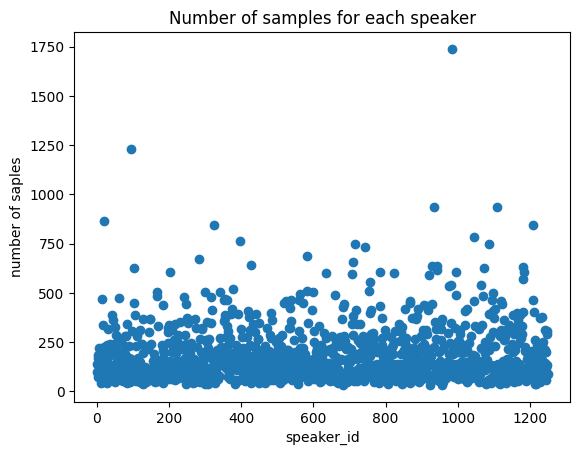

In [31]:
plt.scatter(speaker_mfcc_db.groupby('speaker_id').size().sort_values().index, speaker_mfcc_db.groupby('speaker_id').size().sort_values().values)
plt.title('Number of samples for each speaker')
plt.xlabel('speaker_id')
plt.ylabel('number of saples')

**We can decide what speaker_ids to keep in our dataset based on the number of samples**.

e.g. if we want at least 100 samples per speaker to have enough for training, validation, test (60, 20, 20)

In [14]:
min_num_samples = 100
speaker_mfcc_db_subset = speaker_mfcc_db[speaker_mfcc_db["speaker_id"].isin(speaker_mfcc_db.groupby('speaker_id').size()[speaker_mfcc_db.groupby('speaker_id').size() >= min_num_samples].index)]
number_speaker_ids = len(np.unique(speaker_mfcc_db_subset["speaker_id"]))

print(f"{number_speaker_ids} speakers in this subset, each with at least {min_num_samples} samples")

1148 speakers in this subset, each with at least 100 samples


In [12]:
mfcc_ids_subset = speaker_mfcc_db_subset["mfcc_id"].values

In [13]:
mfcc_channel_db_subset = mfcc_channel_db[mfcc_channel_db.index.isin(mfcc_ids_subset)]

## Preprocessing

In [14]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [15]:
def get_datasets(speaker_mfcc_db, mfcc_channel_db, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [16]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db_subset['speaker_id']))


In [ ]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db_subset, mfcc_channel_db_subset,
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

In [ ]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)